# Ch10: Deep Learning

In [1]:
from glob import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline
sns.set_theme()

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers

In [3]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 42


## Conceptual

### **Q1**


**(a)** I'm using an LLM to generate code to draw the simple neural network, I only do this for tedious tasks, and the book just asks to draw it so a simple pen&paper/illustrator drawing would suffice anyway.

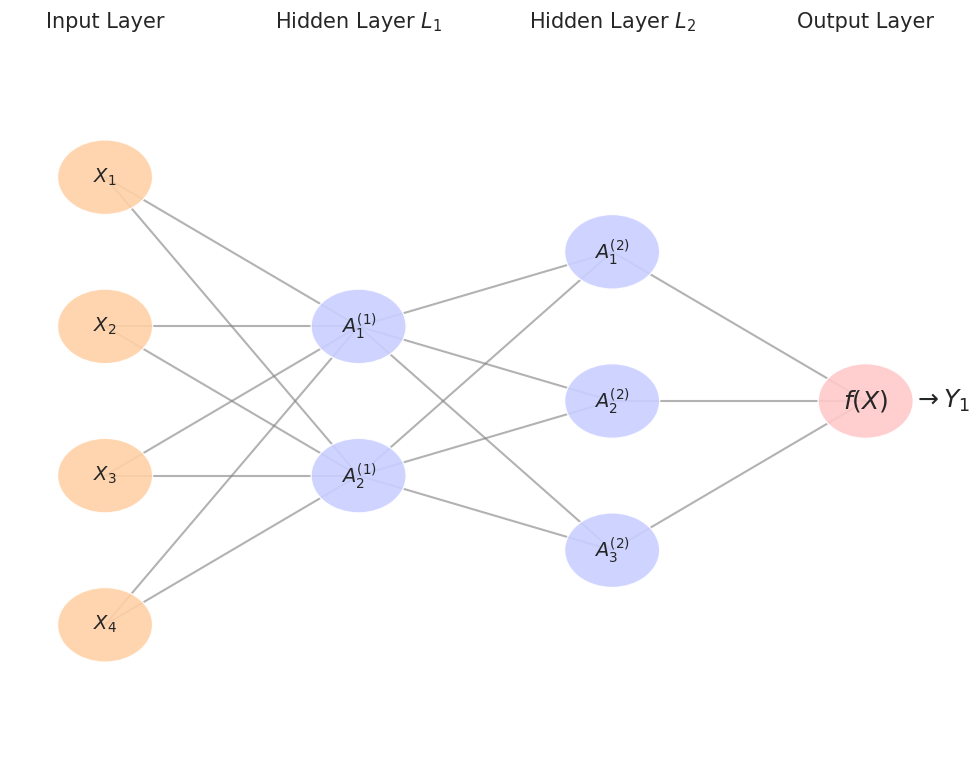

In [4]:
def draw_neural_net():
    """
    Draws a specific neural network with a [4, 2, 3, 1] architecture.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    ax.axis("off")

    # --- Configuration ---
    layer_sizes = [4, 2, 3, 1]
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Colors
    input_color = "#FFD1A6"
    hidden_color = "#C9D0FF"
    output_color = "#FFC9C9"

    node_radius = v_spacing / 4

    # --- Draw Nodes and Edges ---
    # Store node positions to draw edges later
    node_positions = []
    for n, layer_size in enumerate(layer_sizes):
        layer_positions = []
        layer_top = v_spacing * (layer_size - 1) / 2.0 + (top + bottom) / 2.0
        for m in range(layer_size):
            x = n * h_spacing + left
            y = layer_top - m * v_spacing
            layer_positions.append((x, y))

            # Determine color
            if n == 0:
                color = input_color
            elif n < len(layer_sizes) - 1:
                color = hidden_color
            else:
                color = output_color

            circle = plt.Circle(
                (x, y), radius=node_radius, color=color, ec="white", zorder=4, alpha=0.9
            )
            ax.add_artist(circle)
        node_positions.append(layer_positions)

    # --- Draw Edges ---
    for n, (layer_a, layer_b) in enumerate(
        zip(node_positions[:-1], node_positions[1:])
    ):
        for pos_a in layer_a:
            for pos_b in layer_b:
                line = plt.Line2D(
                    [pos_a[0], pos_b[0]],
                    [pos_a[1], pos_b[1]],
                    c="grey",
                    zorder=1,
                    alpha=0.6,
                )
                ax.add_artist(line)

    # --- Add Text and Labels ---
    # Layer Labels
    ax.text(left, top + 0.1, "Input Layer", ha="center", fontsize=15)
    ax.text(
        left + h_spacing, top + 0.1, r"Hidden Layer $L_1$", ha="center", fontsize=15
    )
    ax.text(
        left + 2 * h_spacing, top + 0.1, r"Hidden Layer $L_2$", ha="center", fontsize=15
    )
    ax.text(right, top + 0.1, "Output Layer", ha="center", fontsize=15)

    # Node Labels
    # Input Layer
    for i, pos in enumerate(node_positions[0]):
        ax.text(
            pos[0],
            pos[1],
            rf"$X_{i + 1}$",
            ha="center",
            va="center",
            fontsize=14,
            zorder=5,
        )
    # Hidden Layer 1
    for i, pos in enumerate(node_positions[1]):
        ax.text(
            pos[0],
            pos[1],
            rf"$A_{i + 1}^{{(1)}}$",
            ha="center",
            va="center",
            fontsize=14,
            zorder=5,
        )
    # Hidden Layer 2
    for i, pos in enumerate(node_positions[2]):
        ax.text(
            pos[0],
            pos[1],
            rf"$A_{i + 1}^{{(2)}}$",
            ha="center",
            va="center",
            fontsize=14,
            zorder=5,
        )
    # Output Layer
    pos = node_positions[3][0]
    ax.text(pos[0], pos[1], r"$f(X)$", ha="center", va="center", fontsize=18, zorder=5)

    ax.text(
        pos[0] + 0.08,
        pos[1],
        r"$\rightarrow Y_1$",
        ha="center",
        va="center",
        fontsize=18,
        zorder=5,
    )

    plt.tight_layout()
    plt.show()


draw_neural_net()

**(b)** Using the same notation as the book to denote the $k\text{th}$ cell of the $j\text{th}$ hidden layer $A^{(j)}_{k}$, and considering 2 hidden layers, and denoting the number of cells in a hidden layer as $K_{j}$:

$$
p = 4 \qquad K_1 = 2 \qquad K_2 = 3
$$

$$
f(X) = \beta_0 + \sum^{K_2}_{l = 1} \beta_l A^{(2)}_{l}
$$


Assuming the activation function is the ReLU denoted by $(x)_+$, we'll start by expanding $A^{(1)}_{k}$ and $A^{(2)}_{l}$

\begin{align*}
A^{(1)}_{k} &= h^{(1)}_{k} (X) \\

&= (w^{(1)}_{k0} + \sum^{p}_{j=1} w^{(1)}_{kj} X_j)_+ \\

&= (w^{(1)}_{k0} + w^{(1)}_{k1} X_1 + w^{(1)}_{k2} X_2 + w^{(1)}_{k3} X_3 + w^{(1)}_{k4} X_4 )_+
\end{align*}

Substituing for $k = 1, 2$ we get the equations for the two cells of the first hidden layer:

\begin{align*}
A^{(1)}_{1} &= (w^{(1)}_{10} + w^{(1)}_{11} X_1 + w^{(1)}_{12} X_2 + w^{(1)}_{13} X_3 + w^{(1)}_{14} X_4 )_+ \\

A^{(1)}_{2} &= (w^{(1)}_{20} + w^{(1)}_{21} X_1 + w^{(1)}_{22} X_2 + w^{(1)}_{23} X_3 + w^{(1)}_{24} X_4 )_+

\qquad (1)
\end{align*}


Now we'll use these two hidden cells as input for the second hidden layer:

\begin{align*}
A^{(2)}_{l} &= h^{(2)}_{l} (X) \\

&= (w^{(2)}_{l0} + \sum^{K_1}_{k=1} w^{(1)}_{lk} A^{(1)}_k)_+ \\

&= (w^{(2)}_{l0} + w^{(2)}_{l1} A^{(1)}_1 + w^{(2)}_{l2} A^{(1)}_2)_+
\end{align*}

\begin{align*}
A^{(2)}_{1} &= (w^{(2)}_{10} + w^{(2)}_{11} A^{(1)}_1 + w^{(2)}_{12} A^{(1)}_2)_+ \\
A^{(2)}_{2} &= (w^{(2)}_{20} + w^{(2)}_{21} A^{(1)}_1 + w^{(2)}_{22} A^{(1)}_2)_+ \qquad (2) \\
A^{(2)}_{3} &= (w^{(2)}_{30} + w^{(2)}_{31} A^{(1)}_1 + w^{(2)}_{32} A^{(1)}_2)_+
\end{align*}

And now back to the equation for the output layer:

\begin{align*}

f(X) &= \beta_0 + \sum^{K_2}_{l = 1} \beta_l A^{(2)}_{l} \\

f(X) &= \beta_0 + \beta_1 A^{(2)}_1 + \beta_2 A^{(2)}_2 + \beta_3 A^{(2)}_3
\end{align*}


Substituting using the sets of equations $(2)$ and $(1)$ you can get to the most explicit form for $f(X)$, but I won't do the final substitution as that would be way too explicit and it can't be simplified due to the nested ReLU functions.

**(c)** We'll assume the following values for the inputs and the coefficients:


\begin{align*}
&X_1 = 0 \quad X_2 = -1 \quad X_3 = 1 \quad X_4 = 0\quad\\[1em]

&w^{(1)}_{10} = 1 \quad w^{(1)}_{11} = 0 \quad w^{(1)}_{12} = 3 \quad w^{(1)}_{13} = 0 \quad w^{(1)}_{14} = 4 \\
&w^{(1)}_{20} = -2 \quad w^{(1)}_{21} = 2 \quad w^{(1)}_{22} = 1 \quad w^{(1)}_{23} = 2 \quad w^{(1)}_{24} = -1 \\[1em]
&w^{(2)}_{10} = -2 \quad w^{(2)}_{11} = 0 \quad w^{(2)}_{12} = 1 \\
&w^{(2)}_{20} = 4 \quad w^{(2)}_{21} = -1 \quad w^{(2)}_{22} = 0 \\
&w^{(2)}_{30} = -1 \quad w^{(2)}_{31} = 2 \quad w^{(2)}_{32} = -3 \\[1em]

&\beta_0 = 2 \quad \beta_1 = -3 \quad \beta_2 = 1 \quad \beta_3 = -1
\end{align*}

I really just wanna use numpy and linear algebra here but we'll bear with it for a bit.

In [5]:
# Inputs
X1, X2, X3, X4 = 0, -1, 1, 0

# First hidden layer weights
w1_10 = 1
w1_11 = 0
w1_12 = 3
w1_13 = 0
w1_14 = 4

w1_20 = -2
w1_21 = 2
w1_22 = 1
w1_23 = 2
w1_24 = -1

# Second hidden layer weights
w2_10 = -2
w2_11 = 0
w2_12 = 1

w2_20 = 4
w2_21 = -1
w2_22 = 0

w2_30 = -1
w2_31 = 2
w2_32 = -3

# Output layer coefficients
beta_0 = 2
beta_1 = -3
beta_2 = 1
beta_3 = -1

First we'll find $A^{(1)}_{1}$ and $A^{(1)}_{2}$ using the set of equations $(1)$:

\begin{align*}
A^{(1)}_{1} &= (w^{(1)}_{10} + w^{(1)}_{11} X_1 + w^{(1)}_{12} X_2 + w^{(1)}_{13} X_3 + w^{(1)}_{14} X_4 )_+ \\

A^{(1)}_{2} &= (w^{(1)}_{20} + w^{(1)}_{21} X_1 + w^{(1)}_{22} X_2 + w^{(1)}_{23} X_3 + w^{(1)}_{24} X_4 )_+
\end{align*}

In [6]:
A11 = w1_10 + w1_11 * X1 + w1_12 * X2 + w1_13 * X3 + w1_14 * X4
print(A11)
A11 = A11 if A11 > 0 else 0
A11

-2


0

In [7]:
A12 = w1_20 + w1_21 * X1 + w1_22 * X2 + w1_23 * X3 + w1_24 * X4
print(A12)
A12 = A12 if A12 > 0 else 0
A12

-1


0

Well both evaluated to $0$ and didn't activate thanks to our ReLU functions which will make subsequent calculations simple.

Now we'll find $A^{(2)}_{1}$, $A^{(2)}_{2}$, $A^{(2)}_{3}$ using the set of equations $(2)$


Since $A^{(1)}_{1}$ and $A^{(1)}_{2}$ evaulated to $0$, they simplify to the following:

$$
\begin{align*}
A^{(2)}_{1} &= (w^{(2)}_{10})_+ \\
A^{(2)}_{2} &= (w^{(2)}_{20})_+ \\
A^{(2)}_{3} &= (w^{(2)}_{30})_+
\end{align*}
$$

In [8]:
A21 = w2_10 if w2_10 > 0 else 0
A22 = w2_20 if w2_20 > 0 else 0
A23 = w2_30 if w2_30 > 0 else 0

A21, A22, A23

(0, 4, 0)

Finally we'll plug them all in the output layer equation:

$$
f(X) = \beta_0 + \beta_1 A^{(2)}_1 + \beta_2 A^{(2)}_2 + \beta_3 A^{(2)}_3
$$

In [9]:
fx = beta_0 + beta_1 * A21 + beta_2 * A22 + beta_3 * A23
fx

6

And we can see that given our coefficients and inputs $f(X)$ evaluates to $6$.

**(d)** There's a total of $23$ parameters. $4 \times 2 + 2 = 10$ for the first hidden layer, $2 \times 3 + 3 = 9$ for the second hidden layer, and $3 \times 1 + 1 = 4$ for the output layer.    


### **Q2**


**(a)** Starting with the softmax from $(10.13)$

$$
f_m(X) = \text{Pr}(Y = m | X) = \frac{e^{Z_m}}{\sum^9_{l=0} e^{Z_l}}
$$

Adding a constant $c$ to each $Z_l$ (this includes $Z_m$ as well):


\begin{align*}
\text{Pr}(Y = m | X) &= \frac{e^{Z_m}}{e^{Z_0} + e^{Z_1} + e^{Z_2} + e^{Z_3} + e^{Z_4} + e^{Z_5} + e^{Z_6} + e^{Z_7} + e^{Z_8} + e^{Z_9}} \\

&= \frac{e^{Z_m+c}}{e^{Z_0 + c} + e^{Z_1 + c} + e^{Z_2 + c} + e^{Z_3 + c} + e^{Z_4 + c} + e^{Z_5 + c} + e^{Z_6 + c} + e^{Z_7 + c} + e^{Z_8 + c} + e^{Z_9 + c}} \\


&= e^{-c} e^c \frac{e^{Z_m}}{e^{Z_0} + e^{Z_1} + e^{Z_2} + e^{Z_3} + e^{Z_4} + e^{Z_5} + e^{Z_6} + e^{Z_7} + e^{Z_8} + e^{Z_9}} \\

&= \frac{e^{Z_m}}{e^{Z_0} + e^{Z_1} + e^{Z_2} + e^{Z_3} + e^{Z_4} + e^{Z_5} + e^{Z_6} + e^{Z_7} + e^{Z_8} + e^{Z_9}} \\

&= \frac{e^{Z_m}}{\sum^9_{l=0} e^{Z_l}}

\end{align*}

And the probability remains unchanged.

**(b)** Starting with the softmax from $(4.13)$

$$
\text{Pr}(Y=k|X=x) = \frac{e^{\beta_{k0} + \beta_{k1}x_1 + \dots + \beta_{kp}x_p}}{\sum_{l=1}^{K} e^{\beta_{l0} + \beta_{l1}x_1 + \dots + \beta_{lp}x_p}} 
$$

Adding constants $c_j, j = 0, 1, ..., p$ to each of the corresponding coefficients for each of the classes:

$$
\text{Pr}(Y=k|X=x) = \frac{e^{(\beta_{k0} + c_0) + (\beta_{k1}  + c_1) x_1 + \dots + (\beta_{kp}  + c_p)x_p}}{\sum_{l=1}^{K} e^{(\beta_{l0} + c_0) + (\beta_{l1} + c_1)x_1 + \dots + (\beta_{lp} + c_p)x_p}} 
$$

Factoring out $e^{c_0 + c_1 x_1 + \dots + c_p x_p}$ from the numerator and denominator:


\begin{align*}
\text{Pr}(Y=k|X=x) &= \frac{e^{c_0 + c_1 x_1 + \dots + c_p x_p}}{e^{c_0 + c_1 x_1 + \dots + c_p x_p}} \frac{e^{\beta_{k0} + \beta_{k1}x_1 + \dots + \beta_{kp}x_p}}{\sum_{l=1}^{K} e^{\beta_{l0} + \beta_{l1}x_1 + \dots + \beta_{lp}x_p}} \\

&= \frac{e^{\beta_{k0} + \beta_{k1}x_1 + \dots + \beta_{kp}x_p}}{\sum_{l=1}^{K} e^{\beta_{l0} + \beta_{l1}x_1 + \dots + \beta_{lp}x_p}} 

\end{align*}

And the probability remains unchanged.


### **Q3**

The negative multionmial log-likelihood when there are $M = 2$ looks like this:

$$
- \sum_{i=1}^{n} \sum_{m=0}^{1} y_{im} \log(f_m(x_i)) 
$$

And the likelihood expression $(4.5)$:

$$
\ell(\beta_0, \beta_1) = \prod_{i:y_i=1} p(x_i) \prod_{i':y_{i'}=0} (1-p(x_{i'})) \\
$$

Show that:

$$
- \sum_{i=1}^{n} \sum_{m=0}^{1} y_{im} \log(f_m(x_i)) = - \log(\ell(\beta_0, \beta_1)) \\
$$

**Solution:**

$$
- \sum_{i=1}^{n} \sum_{m=0}^{1} y_{im} \log(f_m(x_i)) = - \log(\prod_{i:y_i=1} p(x_i) \prod_{i':y_{i'}=0} (1-p(x_{i'}))) \\
$$

Breaking up the log of the products into a sum of logs:

$$
- \sum_{i=1}^{n} \sum_{m=0}^{1} y_{im} \log(f_m(x_i)) = - \log(\prod_{i:y_i=1} p(x_i)) - \log(\prod_{i':y_{i'}=0} (1-p(x_{i'}))) \\
$$


Since $f_m(x_i)$ is the predicted probability function for the $m\text{th}$ class (as in the probability that $x_i$ belongs to class $m$), we can replace the probability function of each class with this general form:

$$
f_1(x_i) = p(x_i) \quad f_0(x_i) = 1 - p(x_i)
$$

And breaking up the log of the products into a sum of logs again:

$$
= - \sum_{i:y_i=1} \log(f_1(x_i)) - \sum_{i':y_{i'}=0} \log(f_0(x_i)) 
$$

Now we can replace the two sums with one sum over all $i$ up to $n$, and an indicator variable $y_{im}$ which evaluates to $1$ if the $i\text{th}$ input $x_i$ is the true class $m$ and to $0$ if it's not the true class.

$$
= - \sum_{i=1}^{n} \sum_{m=0}^{1} y_{im} \log(f_m(x_i))
$$

We can see that we arrived at the form we set out to prove which is the negative multinomial log-likelihood for 2 classes. 


### **Q4**


**(a)** I used this tool [NN-SVG](https://alexlenail.me/NN-SVG/LeNet.html) to create the image below.

Having 5x5 filters and no padding results in the images shrinking by 4 in each dimension hence 28x28.

![NN](./images/nnsvg.png)

**(b)** The model has **78** parameters, 75 weights for the three 5x5 filters and 3 more for their biases.



**(c)** The constraints are local connectivity, and weight sharing.

Feed-forward neural networks are fully connected, which means every neuron in a layer is connected to every neuron in the previous layer, however in CNNs every neuron is only connected to a 5x5 "patch" of the input image.

In Feed-forward neural networks, every connection has its own unique weight, however in CNNs the weights are shared via the kernels that sweep across the image.

**(d)** The input layer would have $32 \times 32= 1024$ neurons, and the hidden layer would have $3 \times 28 \times 28 = 2352$ neurons.

For a total of:

$$
1024 \times 2352 = 2,408,448 \quad \text{weights}
$$

There's also $2352$ biases I didn't add as the question specifically asked for weights not parameters.

This really puts into perspective how efficient CNNs are.


### **Q5**


It's because each of these metrics measures different things, the $R^2$ measures the variance in the data explained by the model, while $\text{MAE}$ measures the average magnitude of the errors in a set of predictions.

The reason for the discrepancy in the ordering is that $R^2$ penalizes large errors, so a model like the Lasso that achieved the lowest $\text{MAE}$ and lowest $R^2$, likely made a few big errors and got penalized by the $R^2$ even though on average it had the lowest $\text{MAE}$ and the closest predictions to the true values out of the all the models.

## Applied

### **Q6** 


**(a)**


In [10]:
def R(beta):
    return np.sin(beta) + beta / 10

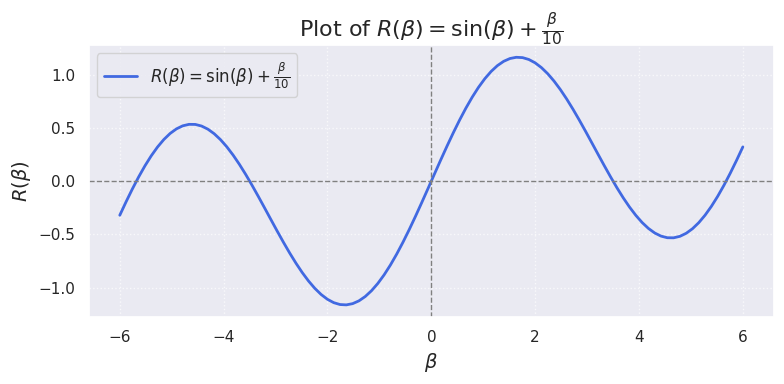

In [11]:
beta = np.linspace(-6, 6, 100)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    beta,
    R(beta),
    label=r"$R(\beta) = \sin(\beta) + \frac{\beta}{10}$",
    color="royalblue",
    linewidth=2,
)
ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel(r"$R(\beta)$", fontsize=14)
ax.set_title(r"Plot of $R(\beta) = \sin(\beta) + \frac{\beta}{10}$", fontsize=16)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.legend(fontsize=12, frameon=True, loc="upper left")
ax.grid(True, linestyle=":", alpha=0.7)
fig.tight_layout()
plt.show()

**(b)**

The derivative of that function is:

$$
\frac{d}{d\beta} R(\beta) = \cos(\beta) + \frac{1}{10} 
$$


**(c)**


In [12]:
# the derivative of R(beta)
def dR(beta):
    return np.cos(beta) + 0.1

We'll define a gradient descent function that keeps looping until it finds a local minimum (when the absolute difference between consecutive $\beta$ values is less than $10^{-6}$, an arbitrary tolerance I chose) and plots the values along the way.

In [13]:
def gradient_descent(beta0, rho, ax):
    beta = beta0
    ax.scatter(beta, R(beta), c="green", marker="o", s=40, zorder=5, label=r"$\beta_0$")
    beta_prev = np.inf

    while np.abs(beta - beta_prev) > 1e-6:
        beta_prev = beta
        beta = beta - rho * dR(beta)
        ax.scatter(beta, R(beta), c="r", zorder=3, s=20)

    ax.scatter(
        beta, R(beta), c="gold", marker="*", s=40, zorder=5, label="local minimum"
    )
    return beta

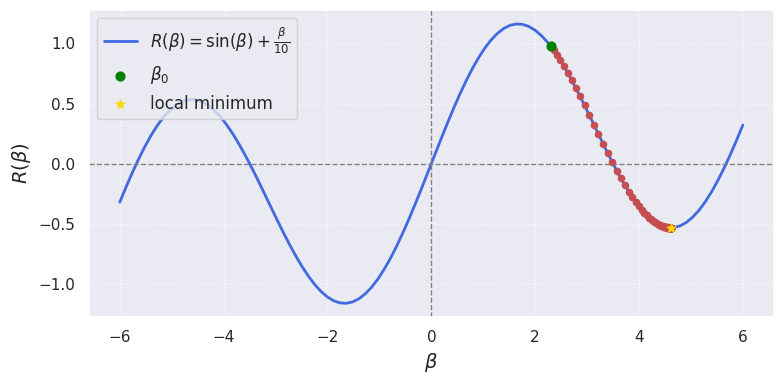

In [14]:
beta = np.linspace(-6, 6, 100)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    beta,
    R(beta),
    label=r"$R(\beta) = \sin(\beta) + \frac{\beta}{10}$",
    color="royalblue",
    linewidth=2,
)

gradient_descent(beta0=2.3, rho=0.1, ax=ax)

ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel(r"$R(\beta)$", fontsize=14)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.legend(fontsize=12, frameon=True, loc="upper left")
ax.grid(True, linestyle=":", alpha=0.7)
fig.tight_layout()
plt.show()


**(d)** Now we'll reuse the same code with $\beta_0 = 1.4$ 

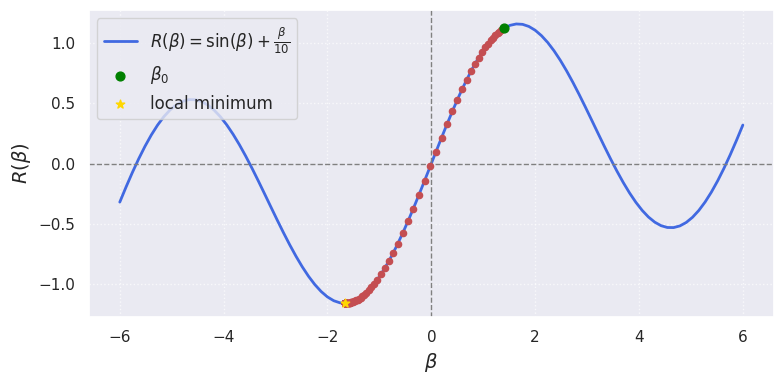

In [15]:
beta = np.linspace(-6, 6, 100)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    beta,
    R(beta),
    label=r"$R(\beta) = \sin(\beta) + \frac{\beta}{10}$",
    color="royalblue",
    linewidth=2,
)


gradient_descent(beta0=1.4, rho=0.1, ax=ax)

ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel(r"$R(\beta)$", fontsize=14)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.legend(fontsize=12, frameon=True, loc="upper left")
ax.grid(True, linestyle=":", alpha=0.7)
fig.tight_layout()
plt.show()

And one more at $\beta_0 = -4$ because I wanted it to see it.

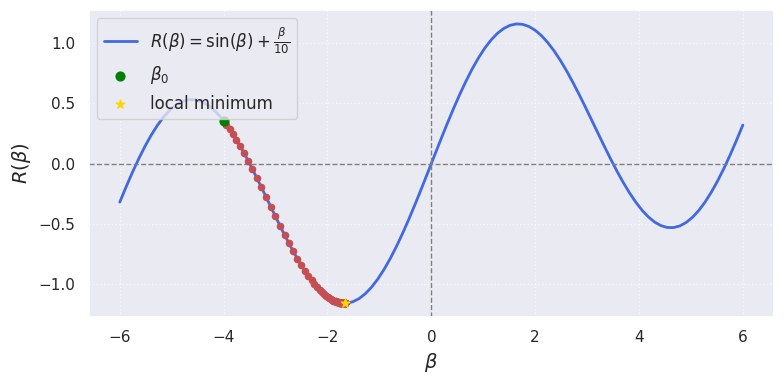

In [16]:
beta = np.linspace(-6, 6, 100)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    beta,
    R(beta),
    label=r"$R(\beta) = \sin(\beta) + \frac{\beta}{10}$",
    color="royalblue",
    linewidth=2,
)


gradient_descent(beta0=-4, rho=0.1, ax=ax)

ax.set_xlabel(r"$\beta$", fontsize=14)
ax.set_ylabel(r"$R(\beta)$", fontsize=14)
ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.legend(fontsize=12, frameon=True, loc="upper left")
ax.grid(True, linestyle=":", alpha=0.7)
fig.tight_layout()
plt.show()


### **Q7** 


In [17]:
default = load_data("Default")
print(default.shape)
default.head()

(10000, 4)


,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [18]:
model = MS(default.columns.drop("default"), intercept=False)
X = model.fit_transform(default).to_numpy()
Y = (default["default"] == "Yes").to_numpy(dtype=int)

In [19]:
X.shape, Y.shape

((10000, 3), (10000,))

In [20]:
np.unique(Y, return_counts=True)

(array([0, 1]), array([9667,  333]))

The null model here would predict all `No` and achieve an accuracy of $0.9667$, so we want our models to beat that.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((7000, 3), (3000, 3), (7000,), (3000,))

In [22]:
# Normalize the data, I'm doing it this way to skip the first
# column (student) which is a binary variable
scaler = StandardScaler()
X_train[:, 1:] = scaler.fit_transform(X_train[:, 1:])
X_test[:, 1:] = scaler.transform(X_test[:, 1:])

In [23]:
X_train[0]

array([ 0.        , -1.71850692,  0.56796666])

In [24]:
class DefaultModel(nn.Module):
    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, 10), nn.ReLU(), nn.Dropout(0.2)
        )
        self.output_layer = nn.Sequential(nn.Linear(10, 2), nn.Softmax(dim=1))

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

In [25]:
default_model = DefaultModel(X.shape[1])

In [26]:
summary(
    default_model,
    input_size=X_train.shape,
    col_names=["input_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [7000, 3]                 [7000, 2]                 --
├─Flatten: 1-1                           [7000, 3]                 [7000, 3]                 --
├─Sequential: 1-2                        [7000, 3]                 [7000, 10]                --
│    └─Linear: 2-1                       [7000, 3]                 [7000, 10]                40
│    └─ReLU: 2-2                         [7000, 10]                [7000, 10]                --
│    └─Dropout: 2-3                      [7000, 10]                [7000, 10]                --
├─Sequential: 1-3                        [7000, 10]                [7000, 2]                 --
│    └─Linear: 2-4                       [7000, 10]                [7000, 2]                 22
│    └─Softmax: 2-5                      [7000, 2]                 [7000, 2]                 --
Total params: 62
Trainable params: 

In [27]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.long)
default_train = TensorDataset(X_train_t, Y_train_t)

In [28]:
X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.long)
default_test = TensorDataset(X_test_t, Y_test_t)


In [29]:
default_dm = SimpleDataModule(
    default_train, default_test, batch_size=64, num_workers=6, validation=default_test
)

In [30]:
default_logger = CSVLogger("logs", name="default")

In [31]:
from torchmetrics import Accuracy

default_module = SimpleModule(
    default_model,
    loss=nn.CrossEntropyLoss(),
    optimizer=torch.optim.RMSprop(default_model.parameters(), lr=0.01),
    metrics={"val_acc": Accuracy(task="multiclass", num_classes=2)},
)

default_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    log_every_n_steps=5,
    logger=default_logger,
    callbacks=[ErrorTracker()],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
# Fit the model using the PyTorch Lightning Trainer
default_trainer.fit(default_module, datamodule=default_dm)


  | Name  | Type             | Params
-------------------------------------------
0 | model | DefaultModel     | 62    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
62        Trainable params
0         Non-trainable params
62        Total params
0.000     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 110/110 [00:01<00:00, 103.94it/s, v_num=2]       

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 110/110 [00:01<00:00, 99.80it/s, v_num=2] 


In [33]:
default_trainer.callback_metrics

{'train_val_acc': tensor(0.9727),
 'train_val_acc_step': tensor(1.),
 'valid_loss': tensor(0.3404),
 'valid_val_acc': tensor(0.9727),
 'train_loss': tensor(0.3396),
 'train_val_acc_epoch': tensor(0.9727)}

In [34]:
# Use the trained PyTorch Lightning model to predict on the test set
default_module.eval()
with torch.no_grad():
    outputs = default_module.model(X_test_t)
    preds = torch.argmax(outputs, dim=1).numpy()

np.unique(preds, return_counts=True)

(array([0, 1]), array([2956,   44]))

In [35]:
print(classification_report(Y_test, preds))
print(f"Accuracy: {accuracy_score(Y_test, preds):.4f}")

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2906
           1       0.64      0.30      0.41        94

    accuracy                           0.97      3000
   macro avg       0.81      0.65      0.70      3000
weighted avg       0.97      0.97      0.97      3000

Accuracy: 0.9727


#### Logistic Regression

Now to fit our simple logistic regression.

In [36]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

In [37]:
preds = lr.predict(X_test)
np.unique(preds, return_counts=True)

(array([0, 1]), array([2965,   35]))

In [38]:
print(classification_report(Y_test, preds))
print(f"Accuracy: {accuracy_score(Y_test, preds):.4f}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2906
           1       0.71      0.27      0.39        94

    accuracy                           0.97      3000
   macro avg       0.85      0.63      0.69      3000
weighted avg       0.97      0.97      0.97      3000

Accuracy: 0.9737


The neural network does slightly better here with more reasonable predictions for the `Yes` class and a macro f1-score of $0.70$ (which could be improved with some tunning), a very slight improvement from the $0.69$ reported by the logistic regression, however it took me a few attempts to get the neural network to that f1-score and above the null prediction threshold ($0.5$ in this case), while it took me one try for the logistic regression. 


### **Q8** 


In [39]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

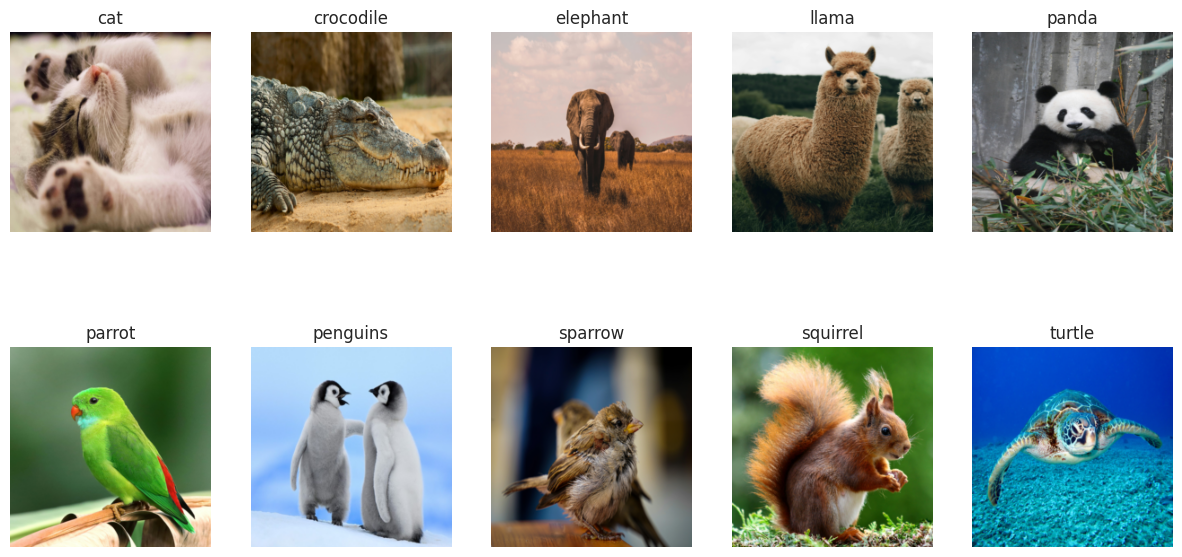

In [40]:
resize = Resize((232, 232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imgfiles = sorted([f for f in glob("animals/*")])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])

num_imgs = len(imgs)
fig, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=((num_imgs // 2) *3, (num_imgs // 2)* 1.5),
)
axes = axes.flatten()

for i, img in enumerate(imgs):
    axes[i].set_title(imgfiles[i].split("/")[1].split(".")[0])
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].grid(False)
    axes[i].axis("off")

In [41]:
imgs = normalize(imgs)
imgs.size()

torch.Size([10, 3, 224, 224])

In [42]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet_model.eval();

In [43]:
img_preds = resnet_model(imgs)

In [44]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:, None]

Loading the imagenet class labels as in the lab.

In [ ]:
labs = json.load(open("./data/imagenet_class_index.json"))
class_labels = pd.DataFrame(
    [(int(k), v[1]) for k, v in labs.items()], columns=["idx", "label"]
)
class_labels = class_labels.set_index("idx")
class_labels = class_labels.sort_index()

In [46]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df["prob"] = img_probs[i]
    img_df = img_df.sort_values(by="prob", ascending=False)[:5]
    print(f"Image: {imgfile}")
    print(img_df.reset_index().drop(columns=["idx"]))
    print()

Image: animals/cat.jpg
          label      prob
0         tabby  0.145170
1  Egyptian_cat  0.135403
2     tiger_cat  0.062935
3          lynx  0.024342
4   Siamese_cat  0.009701

Image: animals/crocodile.jpg
                label      prob
0   African_crocodile  0.433259
1  American_alligator  0.036264
2  leatherback_turtle  0.005696
3       common_iguana  0.002224
4       Komodo_dragon  0.001314

Image: animals/elephant.jpg
              label      prob
0  African_elephant  0.453801
1            tusker  0.130735
2     water_buffalo  0.019638
3   Indian_elephant  0.015725
4                ox  0.005707

Image: animals/llama.jpg
           label      prob
0          llama  0.383909
1            ram  0.028892
2     brown_bear  0.013150
3  Arabian_camel  0.004538
4        bighorn  0.004016

Image: animals/panda.jpg
                 label      prob
0          giant_panda  0.596364
1                teddy  0.005803
2            limousine  0.002477
3  American_black_bear  0.002103
4         l

We can see that it successfully identifies a good number of the images given to it, I might've made it a little easy because a few of the pictures are very popular internet pictures it likely had in its training data, but I don't really have any animal pictures on me.

We can see that it wasn't quite on the mark for the penguins, it chose king penguins but these are emperor penguins. And for the sparrow as well, it picked a junco which in all honesty is close enough, I can barely tell them apart.


### **Q9** 


Loading the data and creating the 12-level factor for the month.

In [47]:
NYSE = load_data("NYSE")
NYSE.index = pd.to_datetime(NYSE.index)
NYSE["month"] = NYSE.index.month

month_names = NYSE.index.strftime("%b")
month_dummies = pd.get_dummies(month_names, prefix="", prefix_sep="")

all_months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
all_days = NYSE["day_of_week"].unique()

month_dummies.index = NYSE.index
month_dummies = month_dummies[all_months]

NYSE = pd.concat([NYSE, month_dummies, pd.get_dummies(NYSE["day_of_week"])], axis=1)
NYSE.drop("month", axis=1, inplace=True)
NYSE.drop("day_of_week", axis=1, inplace=True)

NYSE.head()


,DJ_return,log_volume,log_volatility,train,Jan,Feb,Mar,Apr,May,Jun,...,Aug,Sep,Oct,Nov,Dec,mon,tues,wed,thur,fri
date,,,,,,,,,,,,,,,,,,,,,
1962-12-03,-0.004461,0.032573,-13.127403,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
1962-12-04,0.007813,0.346202,-11.749305,True,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1962-12-05,0.003845,0.525306,-11.665609,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1962-12-06,-0.003462,0.210182,-11.626772,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
1962-12-07,0.000568,0.044187,-11.728130,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True


Now we have dummy variables for months and the day of the week to use later.

In [48]:
NYSE.columns

Index(['DJ_return', 'log_volume', 'log_volatility', 'train', 'Jan', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
       'mon', 'tues', 'wed', 'thur', 'fri'],
      dtype='object')

In [49]:
cols = ["DJ_return", "log_volume", "log_volatility"]
X = pd.DataFrame(
    StandardScaler(with_mean=True, with_std=True).fit_transform(NYSE[cols]),
    columns=NYSE[cols].columns,
    index=NYSE.index,
)
X.shape

(6051, 3)

In [50]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), f"{col}_{lag}", newcol)
X.insert(len(X.columns), "train", NYSE["train"])
X = X.dropna()
X.shape

(6046, 19)

In [51]:
Y, train = X["log_volume"], X["train"]
X = X.drop(columns=["train"] + cols)
X.shape, X.columns

((6046, 15),
 Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
        'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
        'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
        'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
       dtype='object'))

In [52]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [53]:
X_month = pd.concat([X, NYSE[all_months]], axis=1).dropna()
X_month.shape

(6046, 27)

In [54]:
M.fit(X_month[train], Y[train])
M.score(X_month[~train], Y[~train])

0.4167123048568927

Adding the `month` variable slightly increased the $R^2$ score.


### **Q10** 


We'll start by reshaping our data into these flattend short sequences.

In [55]:
ordered_cols = []
for lag in range(5, 0, -1):
    for col in cols:
        ordered_cols.append("{0}_{1}".format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [56]:
X_rnn = X.to_numpy().reshape((-1, 5, 3))
X_rnn.shape

(6046, 5, 3)

Now we'll define our network structure, it's just one `Flatten` layer, and one `Linear` output layer.

In [57]:
class LinearAR(nn.Module):
    def __init__(self):
        super(LinearAR, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(), nn.Linear(15, 1))

    def forward(self, x):
        return torch.flatten(self._forward(x))


nyse_model = LinearAR()

In [58]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

/tmp/ipykernel_30577/2100042546.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
/tmp/ipykernel_30577/2100042546.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


In [59]:
summary(
    nyse_model,
    input_data=X_rnn_t,
    col_names=["input_size", "output_size", "num_params"],
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LinearAR                                 [1770, 5, 3]              [1770]                    --
├─Sequential: 1-1                        [1770, 5, 3]              [1770, 1]                 --
│    └─Flatten: 2-1                      [1770, 5, 3]              [1770, 15]                --
│    └─Linear: 2-2                       [1770, 15]                [1770, 1]                 16
Total params: 16
Trainable params: 16
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.11
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.12

In [60]:
nyse_dm = SimpleDataModule(
    nyse_train, nyse_test, num_workers=10, validation=nyse_test, batch_size=64, seed=1
)

In [61]:
nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(
    nyse_model, optimizer=nyse_optimizer, metrics={"r2": R2Score()}
)


In [62]:
nyse_trainer = Trainer(deterministic=True, max_epochs=200, callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module, datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/crim/miniconda3/envs/islp/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type     | Params
-----------------------------------
0 | model | LinearAR | 16    
1 | loss  | MSELoss  | 0     
-----------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 67/67 [00:00<00:00, 127.75it/s, v_num=6]        

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 67/67 [00:00<00:00, 122.12it/s, v_num=6]


In [63]:
nyse_trainer.test(nyse_module, datamodule=nyse_dm)

Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 293.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6193305850028992
         test_r2            0.41222506761550903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6193305850028992, 'test_r2': 0.41222506761550903}]

We can see that it achieves a test $R^2$ of $0.413$ which is pretty close to the $0.4128$ achieved by the linear AR model we fit earlier using `LinearRegression()` and also shown in the lab in section `10.9.6`.

The advantages of this approach where we use the same sequences produced for the RNN model and flatten them, is that we can fit a linear AR model using the same pipeline used to fit the RNN model (or other neural networks), and transform the data without having to make a separate pipeline to build the matrix which could introduce inconsistencies between the two processes.

The disadvantages are that this approach is less intuitive than the other one, and is a hassle to set up. So if you're just fitting a simple linear AR model, the first approach would be better as it's a straight forward transformation (create lag variables and append them to the feature matrix).


### **Q11** 


Using the same `NonLinearARModel` from the lab and changing the number of inputs from `20` to `15`.

In [64]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(
            nn.Flatten(),
            nn.Linear(15, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return torch.flatten(self._forward(x))


nl_model = NonLinearARModel()

In [65]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(), lr=0.001)
nl_module = SimpleModule.regression(
    nl_model, optimizer=nl_optimizer, metrics={"r2": R2Score()}
)

In [66]:
nl_trainer = Trainer(deterministic=True, max_epochs=100, callbacks=[ErrorTracker()])

nl_trainer.fit(nl_module, datamodule=nyse_dm)
nl_trainer.test(nl_module, datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 545   
1 | loss  | MSELoss          | 0     
-------------------------------------------
545       Trainable params
0         Non-trainable params
545       Total params
0.002     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 67/67 [00:00<00:00, 113.91it/s, v_num=7]         

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 322.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6037485003471375
         test_r2            0.4270131587982178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6037485003471375, 'test_r2': 0.4270131587982178}]

A slightly better test $R^2$ score of $0.426$


### **Q12** 


We'll use the same RNN model defined in the lab `NYSEModel` with a slight tweak to its input size, instead of taking `3` inputs, we'll give it `8`, the `3` features and `5` dummy variables for the day of the week.

In [67]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(8, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)


nyse_model = NYSEModel()

We'll reshape our data so the model can handle it.

In [68]:
# Create lagged day variables
day_lagged_dfs = []
for lag in range(1, 6):
    lagged_days = NYSE[all_days].shift(lag)
    lagged_days.columns = ["{0}_{1}".format(col, lag) for col in all_days]
    day_lagged_dfs.append(lagged_days)

# Combine all lagged day variables
all_lagged_days = pd.concat(day_lagged_dfs, axis=1)

ordered_cols = []
for lag in range(5, 0, -1):
    for col in cols:
        ordered_cols.append("{0}_{1}".format(col, lag))
    for day in all_days:
        ordered_cols.append("{0}_{1}".format(day, lag))

X_day = pd.concat([X, all_lagged_days], axis=1).dropna()
X_day = X_day.reindex(columns=ordered_cols)
X_day.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'mon_5', 'tues_5',
       'wed_5', 'thur_5', 'fri_5', 'DJ_return_4', 'log_volume_4',
       'log_volatility_4', 'mon_4', 'tues_4', 'wed_4', 'thur_4', 'fri_4',
       'DJ_return_3', 'log_volume_3', 'log_volatility_3', 'mon_3', 'tues_3',
       'wed_3', 'thur_3', 'fri_3', 'DJ_return_2', 'log_volume_2',
       'log_volatility_2', 'mon_2', 'tues_2', 'wed_2', 'thur_2', 'fri_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1', 'mon_1', 'tues_1',
       'wed_1', 'thur_1', 'fri_1'],
      dtype='object')

In [69]:
X_rnn = X_day.to_numpy().reshape((-1, 5, 8))
X_rnn.shape

(6046, 5, 8)

In [70]:
X_rnn[0]

array([[-0.549823342766741, 0.17507496702556102, -4.357077862202008,
        True, False, False, False, False],
       [0.9051999460160775, 1.5172907075939488, -2.5290576496438395,
        False, True, False, False, False],
       [0.43481275277098835, 2.283789366833881, -2.4180369366103514,
        False, False, True, False, False],
       [-0.43139672833835296, 0.9351755810204748, -2.366520943622522,
        False, False, False, True, False],
       [0.04634026480119069, 0.2247785773771588, -2.5009701018617014,
        False, False, False, False, True]], dtype=object)

In [71]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets


/tmp/ipykernel_30577/3890359531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
/tmp/ipykernel_30577/3890359531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


In [72]:
summary(
    nyse_model,
    input_data=X_rnn_t,
    col_names=["input_size", "output_size", "num_params"],
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 8]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 8]              [1770, 5, 12]             264
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 277
Trainable params: 277
Non-trainable params: 0
Total mult-adds (M): 2.36
Input size (MB): 0.28
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 1.15

In [73]:
nyse_dm = SimpleDataModule(
    nyse_train, nyse_test, num_workers=10, validation=nyse_test, batch_size=64
)

nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(
    nyse_model, optimizer=nyse_optimizer, metrics={"r2": R2Score()}
)


In [74]:
nyse_trainer = Trainer(deterministic=True, max_epochs=100, callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module, datamodule=nyse_dm)
nyse_trainer.test(nyse_module, datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 277   
1 | loss  | MSELoss   | 0     
------------------------------------
277       Trainable params
0         Non-trainable params
277       Total params
0.001     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 67/67 [00:00<00:00, 117.66it/s, v_num=8]         

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 295.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5678530931472778
         test_r2            0.4610797166824341
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5678530931472778, 'test_r2': 0.4610797166824341}]

We can see that using the `day_of_week` variable greatly improves the test $R^2$ score.

In [75]:
del (NYSE, 
     X,
     X_month,
     X_day,
     X_rnn,
     X_rnn_t,
     X_test,
     X_test_t,
     X_train,
     X_train_t,
     Y_t,
     Y_test,
     Y_test_t,
     Y_train,
     Y_train_t,
     nyse_dm,
     nyse_model,
     nyse_module,
     nyse_train,
     nyse_test)


### **Q13** 


In [76]:
from ISLP.torch.imdb import load_tensor

max_num_workers = 10
(imdb_train, imdb_test) = load_tensor(root="data/IMDB")
imdb_dm = SimpleDataModule(
    imdb_train,
    imdb_test,
    validation=2000,
    num_workers=min(6, max_num_workers),
    batch_size=512,
    seed=0,
)


We'll train 4 models on this IMDB dataset, we'll use the same `IMDBModel` used in the lab but we'll increase the number of hidden units at each layer to 32, then to 64, then we'll try each again with $30%$ dropout regularization.

#### 32 Hidden Units, No Dropout

Starting with the model with 32 hidden units in each of the 2 layers

In [77]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self._forward = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            
            nn.Linear(32, 32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self._forward(x)
        return torch.flatten(x)

imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Sequential: 1-1                        [25000, 10003]            [25000, 1]                --
│    └─Linear: 2-1                       [25000, 10003]            [25000, 32]               320,128
│    └─ReLU: 2-2                         [25000, 32]               [25000, 32]               --
│    └─Linear: 2-3                       [25000, 32]               [25000, 32]               1,056
│    └─ReLU: 2-4                         [25000, 32]               [25000, 32]               --
│    └─Linear: 2-5                       [25000, 32]               [25000, 1]                33
Total params: 321,217
Trainable params: 321,217
Non-trainable params: 0
Total mult-adds (G): 8.03
Input size (MB): 1000.30
Forward/backward pass size (MB): 13.00
Params size (MB): 1.28
Estimated Total Size (MB): 1014.58

In [78]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer,)
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [79]:
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

imdb_trainer.test(imdb_module, 
                  datamodule=imdb_dm)


  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 321 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
321 K     Trainable params
0         Non-trainable params
321 K     Total params
1.285     Total estimated model params size (MB)


/home/crim/miniconda3/envs/islp/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 45/45 [00:00<00:00, 45.58it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 70.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8501600027084351
        test_loss           1.3700613975524902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3700613975524902, 'test_accuracy': 0.8501600027084351}]

#### 64 Hidden Units, No Dropout

In [80]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self._forward = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            
            nn.Linear(64, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self._forward(x)
        return torch.flatten(x)

imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Sequential: 1-1                        [25000, 10003]            [25000, 1]                --
│    └─Linear: 2-1                       [25000, 10003]            [25000, 64]               640,256
│    └─ReLU: 2-2                         [25000, 64]               [25000, 64]               --
│    └─Linear: 2-3                       [25000, 64]               [25000, 64]               4,160
│    └─ReLU: 2-4                         [25000, 64]               [25000, 64]               --
│    └─Linear: 2-5                       [25000, 64]               [25000, 1]                65
Total params: 644,481
Trainable params: 644,481
Non-trainable params: 0
Total mult-adds (G): 16.11
Input size (MB): 1000.30
Forward/backward pass size (MB): 25.80
Params size (MB): 2.58
Estimated Total Size (MB): 1028.6

In [81]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [82]:
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

imdb_trainer.test(imdb_module, 
                  datamodule=imdb_dm)


  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 644 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
644 K     Trainable params
0         Non-trainable params
644 K     Total params
2.578     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 45/45 [00:00<00:00, 45.28it/s, v_num=5]          

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 79.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8576800227165222
        test_loss           1.5806759595870972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5806759595870972, 'test_accuracy': 0.8576800227165222}]

#### 32 Hidden Units, 30% Dropout 

In [83]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self._forward = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self._forward(x)
        return torch.flatten(x)

imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Sequential: 1-1                        [25000, 10003]            [25000, 1]                --
│    └─Linear: 2-1                       [25000, 10003]            [25000, 32]               320,128
│    └─ReLU: 2-2                         [25000, 32]               [25000, 32]               --
│    └─Dropout: 2-3                      [25000, 32]               [25000, 32]               --
│    └─Linear: 2-4                       [25000, 32]               [25000, 32]               1,056
│    └─ReLU: 2-5                         [25000, 32]               [25000, 32]               --
│    └─Dropout: 2-6                      [25000, 32]               [25000, 32]               --
│    └─Linear: 2-7                       [25000, 32]               [25000, 1]                33
Total params: 321,217
Train

In [84]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [85]:
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

imdb_trainer.test(imdb_module, 
                  datamodule=imdb_dm)


  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 321 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
321 K     Trainable params
0         Non-trainable params
321 K     Total params
1.285     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 45/45 [00:01<00:00, 44.90it/s, v_num=6]          

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 78.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8637599945068359
        test_loss            1.203994870185852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.203994870185852, 'test_accuracy': 0.8637599945068359}]

#### 64 Hidden Units, 30% Dropout 

In [86]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self._forward = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self._forward(x)
        return torch.flatten(x)

imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Sequential: 1-1                        [25000, 10003]            [25000, 1]                --
│    └─Linear: 2-1                       [25000, 10003]            [25000, 64]               640,256
│    └─ReLU: 2-2                         [25000, 64]               [25000, 64]               --
│    └─Dropout: 2-3                      [25000, 64]               [25000, 64]               --
│    └─Linear: 2-4                       [25000, 64]               [25000, 64]               4,160
│    └─ReLU: 2-5                         [25000, 64]               [25000, 64]               --
│    └─Dropout: 2-6                      [25000, 64]               [25000, 64]               --
│    └─Linear: 2-7                       [25000, 64]               [25000, 1]                65
Total params: 644,481
Train

In [87]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [88]:
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

imdb_trainer.test(imdb_module, 
                  datamodule=imdb_dm)


  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 644 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
644 K     Trainable params
0         Non-trainable params
644 K     Total params
2.578     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 45/45 [00:01<00:00, 39.26it/s, v_num=7]          

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing DataLoader 0: 100%|██████████| 49/49 [00:00<00:00, 81.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8681600093841553
        test_loss           1.0569698810577393
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0569698810577393, 'test_accuracy': 0.8681600093841553}]

We can see that increasing the number of hidden units at each of the layers resulted in a noticeable increase in test accuracy.

Without dropout I got the following test accuracy for each:
- 32 hidden units: $85.02\%$
- 64 hidden units: $85.77\%$

Adding dropout further increases the test accuracy to the following values:
- 32 hidden units: $86.38\%$
- 64 hidden units: $86.82\%$

Note: these numbers could easily change with the slightest modifications to the networks and the seed, but the changes shouldn't be too significant.